In [1]:
from datetime import datetime
import settings.config_tourism_dataset as cfg
import pandas as pd
import numpy as np


preprocessed_dataset_folder = cfg.preprocessed_dataset_folder
individual_rs_strategy = cfg.individual_rs_strategy
aggregation_strategies = cfg.aggregation_strategies
recommendations_number = cfg.recommendations_number
individual_rs_validation_folds_k = cfg.individual_rs_validation_folds_k
group_rs_evaluation_folds_k = cfg.group_rs_evaluation_folds_k
evaluation_strategy = cfg.evaluation_strategy
metrics = cfg.metrics
evaluation_ground_truth = cfg.evaluation_ground_truth
group_types = cfg.group_types

display(cfg.dataset_folder,cfg.preprocessed_dataset_folder)

'tourism_dataset'

'preprocessed_tourism_dataset'

In [2]:
import pandas as pd
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv")

import pickle

group_composition = pickle.load(open(preprocessed_dataset_folder+"/group_composition.pkl", "rb"))
len(group_composition)

79

## Train individual RS / Prepare groundtruth

In [3]:
import pickle
import os
#from individual_rs.individual_rs import IndividualRS
from utils.utility_functions import create_per_user_group_choices,create_per_user_satisfaction

import warnings
warnings.filterwarnings('ignore')
# General pipeline

# creating train-test folds
# split stratified on the users 

from sklearn.model_selection import StratifiedKFold
import itertools

print(datetime.now(), "Select ground-truth for tourism dataset")
current_fold = 0
path_to_fold = preprocessed_dataset_folder+"/fold_"+str(current_fold)

if group_types == "REAL":
    

    group_choices = pd.read_csv(preprocessed_dataset_folder+"/group_choices.csv")
    ground_truth = create_per_user_group_choices(group_composition, group_choices)
    ground_truth.columns = ['user', 'item', 'rating']    
    if not os.path.exists(path_to_fold):
        os.mkdir(path_to_fold)
    pickle.dump(ground_truth, open(path_to_fold+"/test_group_df.pkl", "wb"))
        
    group_choices = pd.read_csv(preprocessed_dataset_folder+"/group_choices.csv")
    user_feedback = pd.read_csv(preprocessed_dataset_folder+"/user_feedback.csv")
        
    ground_truth = create_per_user_satisfaction(group_composition, group_choices, user_feedback)    
    pickle.dump(ground_truth, open(path_to_fold+"/test_satisfaction_df.pkl", "wb"))

    ground_truth = ratings_df[['user', 'item', 'rating']] 
    pickle.dump(ground_truth, open(path_to_fold+"/test_ratings_df.pkl", "wb"))
    
    
    #display(ground_truth)
else:
    print("ERROR: incorrect config file!")
print(datetime.now(), "Done!")


2022-09-18 18:57:35.733499 Select ground-truth for tourism dataset
2022-09-18 18:57:36.802496 Done!


# Construct group recommendations

In [4]:
from utils.utility_functions import generate_group_recommendations_forall_groups

import os
import warnings
warnings.filterwarnings('ignore')
lst = os.listdir(preprocessed_dataset_folder)
folds = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("fold"))]

for f in folds:
    current_fold = int(f.replace("fold_",""))
    path_to_fold = preprocessed_dataset_folder+"/"+f
    
    if group_types == "REAL":
        test_pred_df = ratings_df[['user', 'item', 'rating']]
        test_pred_df.columns = ['user', 'item', 'predicted_rating']
    else:
        train_df = pickle.load(open(path_to_fold+"/train_df.pkl", "rb"))
        test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
        test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))
    

    print(datetime.now(), f+": Generate GRS for all the aggregation strategies and all the groups")
    # - generate the recommendations for all the aggregation strategies and all the groups
    group_recommendations = generate_group_recommendations_forall_groups(test_pred_df, group_composition, cfg.recommendations_number)
    print(datetime.now(), f+": Done")
    
    pickle.dump(group_recommendations, open(path_to_fold+"/group_recommendations.pkl", "wb"))



2022-09-18 18:57:36.825501 fold_0: Generate GRS for all the aggregation strategies and all the groups
2022-09-18 18:57:40.892494 fold_0: Done


# Evaluate group recommendations
### Define evaluation variants

In [5]:
 evaluation_variants = [
     {
         "evaluation_strategy": "COUPLED",
         "evaluation_ground_truth": "GROUP_CHOICES",
         "binarize_feedback": False,
         "inverse_propensity_debiasing": False,
         "feedback_polarity_debiasing": 0.0
     },
     {
         "evaluation_strategy": "COUPLED",
         "evaluation_ground_truth": "USER_RATINGS",
         "binarize_feedback_positive_threshold": 6,
         "binarize_feedback": False,
         "inverse_propensity_debiasing": False,
         "feedback_polarity_debiasing": 0.0
     },
     {
         "evaluation_strategy": "COUPLED",
         "evaluation_ground_truth": "USER_SATISFACTION",
         "binarize_feedback_positive_threshold": 3.5,
         "binarize_feedback": False,
         "inverse_propensity_debiasing": False,
         "feedback_polarity_debiasing": 0.0
     },
 ]

In [6]:
import os
import time
import json
from utils.utility_functions import calculate_inverse_propensity_score,calculate_inverse_propensity_score_user_normalization
from utils.utility_functions import evaluate_group_recommendations_forall_groups

import warnings
warnings.filterwarnings('ignore')

lst = os.listdir(preprocessed_dataset_folder)
folds = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("fold"))]

for ev in evaluation_variants:
    for i in ev.keys():
        setattr(cfg, i, ev[i])

    evaluations = list()
    for f in folds:
        current_fold = int(f.replace("fold_",""))
        path_to_fold = preprocessed_dataset_folder+"/"+f
        
        if group_types == "REAL":
            if cfg.evaluation_ground_truth == "GROUP_CHOICES":
                test_df = pickle.load(open(path_to_fold+"/test_group_df.pkl", "rb"))
            elif cfg.evaluation_ground_truth == "USER_SATISFACTION":
                test_df = pickle.load(open(path_to_fold+"/test_satisfaction_df.pkl", "rb"))
            else:
                test_df = pickle.load(open(path_to_fold+"/test_ratings_df.pkl", "rb"))
            print(test_df.head())
        else:
            train_df = pickle.load(open(path_to_fold+"/train_df.pkl", "rb"))
            test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
            test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))

        group_recommendations = pickle.load(open(path_to_fold+"/group_recommendations.pkl", "rb"))

        # - evaluate the recommendations
        if cfg.evaluation_strategy == "COUPLED":
            ground_truth = test_df
        else:
            ground_truth = test_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")

        if cfg.inverse_propensity_debiasing == True and cfg.evaluation_strategy == "COUPLED":
            propensity_per_item = calculate_inverse_propensity_score(ratings_df, train_df, cfg.inverse_propensity_gamma)
            per_user_propensity_normalization_term = calculate_inverse_propensity_score_user_normalization(propensity_per_item, test_df)
        else:
            #dummies to simplify downstream code
            propensity_per_item = pd.Series({"propensity_score":1.0})
            per_user_propensity_normalization_term = None

        print(datetime.now(), f+": Evaluate Group recommendations")
        #display(ground_truth)
        fold_group_evaluations = evaluate_group_recommendations_forall_groups(
            ground_truth, 
            group_recommendations, 
            group_composition, 
            propensity_per_item, 
            per_user_propensity_normalization_term,
            current_fold,
            cfg.evaluation_ground_truth,            
            cfg.binarize_feedback_positive_threshold,
            cfg.binarize_feedback,
            cfg.feedback_polarity_debiasing        
        )
        print(datetime.now(), "Fold Evaluation DONE")
        #display(fold_group_evaluations)

        evaluations = evaluations + fold_group_evaluations
        #current_fold = current_fold + 1
    eval_df = pd.DataFrame.from_records(evaluations)  
    
    
    
    path_to_eval_folder = preprocessed_dataset_folder+"/eval_"+str(time.time())
    eval_parameters = {key:cfg.__dict__[key] for key in cfg.__dict__.keys() if not (key.startswith('__') or key.startswith('_'))}

    if not os.path.exists(path_to_eval_folder):
        os.mkdir(path_to_eval_folder)
        
    
    pickle.dump(eval_parameters, open(path_to_eval_folder+"/eval_parameters.pkl", "wb"))    
    pickle.dump(eval_df, open(path_to_eval_folder+"/eval_df.pkl", "wb"))
    pickle.dump(group_composition, open(path_to_eval_folder+"/group_composition.pkl", "wb"))
    #for human readability
    with open(path_to_eval_folder+"/eval_parameters.json" , "w" ) as write:
        json.dump( eval_parameters , write )        

    user item rating
0  26323   D5      1
1  26323   D3      2
2  42775   D5      1
3  42775   D3      2
4  41651   D5      1
2022-09-18 18:57:40.943501 fold_0: Evaluate Group recommendations
       user rating  final_rating
item                            
D5    26323      1           1.0
D3    26323      2           1.0
       user rating  final_rating
item                            
D5    42775      1           1.0
D3    42775      2           1.0
       user rating  final_rating
item                            
D5    41651      1           1.0
D3    41651      2           1.0
       user rating  final_rating
item                            
D5    32327      1           1.0
D3    32327      2           1.0
       user rating  final_rating
item                            
D5    26323      1           1.0
D3    26323      2           1.0
       user rating  final_rating
item                            
D5    42775      1           1.0
D3    42775      2           1.0
       user rati

D4    30600      2           1.0
       user rating  final_rating
item                            
D4    89066      1           1.0
D10   89066      2           1.0
       user rating  final_rating
item                            
D4    17384      1           1.0
D10   17384      2           1.0
       user rating  final_rating
item                            
D4    56579      1           1.0
D10   56579      2           1.0
       user rating  final_rating
item                            
D4    62404      1           1.0
D10   62404      2           1.0
       user rating  final_rating
item                            
D4    89066      1           1.0
D10   89066      2           1.0
       user rating  final_rating
item                            
D4    17384      1           1.0
D10   17384      2           1.0
       user rating  final_rating
item                            
D4    56579      1           1.0
D10   56579      2           1.0
       user rating  final_rating
item      

D10   43778      2           1.0
      user rating  final_rating
item                           
D6    9371      1           1.0
D10   9371      2           1.0
       user rating  final_rating
item                            
D6    71238      1           1.0
D10   71238      2           1.0
       user rating  final_rating
item                            
D6    43778      1           1.0
D10   43778      2           1.0
      user rating  final_rating
item                           
D6    9371      1           1.0
D10   9371      2           1.0
       user rating  final_rating
item                            
D6    71238      1           1.0
D10   71238      2           1.0
       user rating  final_rating
item                            
D7    58708      1           1.0
D8    58708      2           1.0
       user rating  final_rating
item                            
D7    74772      1           1.0
D8    74772      2           1.0
      user rating  final_rating
item               

D4    49924      2           1.0
       user rating  final_rating
item                            
D10   66179      1           1.0
D4    66179      2           1.0
       user rating  final_rating
item                            
D10   45608      1           1.0
D4    45608      2           1.0
       user rating  final_rating
item                            
D10   49924      1           1.0
D4    49924      2           1.0
       user rating  final_rating
item                            
D10   66179      1           1.0
D4    66179      2           1.0
       user rating  final_rating
item                            
D10   45608      1           1.0
D4    45608      2           1.0
       user rating  final_rating
item                            
D10   49924      1           1.0
D4    49924      2           1.0
       user rating  final_rating
item                            
D10   66179      1           1.0
D4    66179      2           1.0
       user rating  final_rating
item      

D8    1829      2           1.0
       user rating  final_rating
item                            
D9    39105      1           1.0
D8    39105      2           1.0
       user rating  final_rating
item                            
D9    52966      1           1.0
D8    52966      2           1.0
       user rating  final_rating
item                            
D9    25813      1           1.0
D8    25813      2           1.0
      user rating  final_rating
item                           
D9    1829      1           1.0
D8    1829      2           1.0
       user rating  final_rating
item                            
D9    39105      1           1.0
D8    39105      2           1.0
       user rating  final_rating
item                            
D9    52966      1           1.0
D8    52966      2           1.0
       user rating  final_rating
item                            
D9    25813      1           1.0
D8    25813      2           1.0
      user rating  final_rating
item            

D2    96863      2           1.0
       user rating  final_rating
item                            
D5    62217      1           1.0
D2    62217      2           1.0
       user rating  final_rating
item                            
D5    55827      1           1.0
D2    55827      2           1.0
       user rating  final_rating
item                            
D5    75873      1           1.0
D2    75873      2           1.0
       user rating  final_rating
item                            
D5    48358      1           1.0
D2    48358      2           1.0
       user rating  final_rating
item                            
D5    96863      1           1.0
D2    96863      2           1.0
       user rating  final_rating
item                            
D5    62217      1           1.0
D2    62217      2           1.0
       user rating  final_rating
item                            
D5    55827      1           1.0
D2    55827      2           1.0
       user rating  final_rating
item      

D7    86851      2           1.0
       user rating  final_rating
item                            
D5    94345      1           1.0
D7    94345      2           1.0
       user rating  final_rating
item                            
D5    88835      1           1.0
D7    88835      2           1.0
       user rating  final_rating
item                            
D5    86851      1           1.0
D7    86851      2           1.0
       user rating  final_rating
item                            
D5    94345      1           1.0
D7    94345      2           1.0
       user rating  final_rating
item                            
D5    88835      1           1.0
D7    88835      2           1.0
       user rating  final_rating
item                            
D5    86851      1           1.0
D7    86851      2           1.0
       user rating  final_rating
item                            
D6    26974      1           1.0
D3    26974      2           1.0
       user rating  final_rating
item      

D10   86626      2           1.0
       user rating  final_rating
item                            
D6    30796      1           1.0
D10   30796      2           1.0
       user rating  final_rating
item                            
D6    45600      1           1.0
D10   45600      2           1.0
      user rating  final_rating
item                           
D6    6361      1           1.0
D10   6361      2           1.0
       user rating  final_rating
item                            
D6    86626      1           1.0
D10   86626      2           1.0
       user rating  final_rating
item                            
D6    30796      1           1.0
D10   30796      2           1.0
       user rating  final_rating
item                            
D6    45600      1           1.0
D10   45600      2           1.0
      user rating  final_rating
item                           
D6    6361      1           1.0
D10   6361      2           1.0
       user rating  final_rating
item              

D3    77543      2           1.0
      user rating  final_rating
item                           
D9    9252      1           1.0
D3    9252      2           1.0
       user rating  final_rating
item                            
D9    33134      1           1.0
D3    33134      2           1.0
       user rating  final_rating
item                            
D9    77543      1           1.0
D3    77543      2           1.0
      user rating  final_rating
item                           
D9    9252      1           1.0
D3    9252      2           1.0
       user rating  final_rating
item                            
D9    33134      1           1.0
D3    33134      2           1.0
       user rating  final_rating
item                            
D9    77543      1           1.0
D3    77543      2           1.0
      user rating  final_rating
item                           
D9    9252      1           1.0
D3    9252      2           1.0
       user rating  final_rating
item                  

D5    15056      2           1.0
      user rating  final_rating
item                           
D9    3806      1           1.0
D6    3806      2           1.0
       user rating  final_rating
item                            
D9    98758      1           1.0
D6    98758      2           1.0
       user rating  final_rating
item                            
D9    86963      1           1.0
D6    86963      2           1.0
       user rating  final_rating
item                            
D9    39470      1           1.0
D6    39470      2           1.0
      user rating  final_rating
item                           
D9    3806      1           1.0
D6    3806      2           1.0
       user rating  final_rating
item                            
D9    98758      1           1.0
D6    98758      2           1.0
       user rating  final_rating
item                            
D9    86963      1           1.0
D6    86963      2           1.0
       user rating  final_rating
item              

D7    73914      2           1.0
       user rating  final_rating
item                            
D9    30116      1           1.0
D7    30116      2           1.0
       user rating  final_rating
item                            
D9    76454      1           1.0
D7    76454      2           1.0
       user rating  final_rating
item                            
D9    73914      1           1.0
D7    73914      2           1.0
       user rating  final_rating
item                            
D9    30116      1           1.0
D7    30116      2           1.0
       user rating  final_rating
item                            
D9    76454      1           1.0
D7    76454      2           1.0
       user rating  final_rating
item                            
D9    73914      1           1.0
D7    73914      2           1.0
       user rating  final_rating
item                            
D9    30116      1           1.0
D7    30116      2           1.0
       user rating  final_rating
item      

D10   77309      2           1.0
       user rating  final_rating
item                            
D9    35647      1           1.0
D10   35647      2           1.0
       user rating  final_rating
item                            
D9    37765      1           1.0
D10   37765      2           1.0
       user rating  final_rating
item                            
D9    70508      1           1.0
D10   70508      2           1.0
       user rating  final_rating
item                            
D9    77309      1           1.0
D10   77309      2           1.0
       user rating  final_rating
item                            
D9    35647      1           1.0
D10   35647      2           1.0
       user rating  final_rating
item                            
D9    37765      1           1.0
D10   37765      2           1.0
       user rating  final_rating
item                            
D9    70508      1           1.0
D10   70508      2           1.0
       user rating  final_rating
item      

D3    14352      2           1.0
       user rating  final_rating
item                            
D10   57410      1           1.0
D3    57410      2           1.0
       user rating  final_rating
item                            
D10   98071      1           1.0
D3    98071      2           1.0
       user rating  final_rating
item                            
D10   57918      1           1.0
D3    57918      2           1.0
       user rating  final_rating
item                            
D10   14352      1           1.0
D3    14352      2           1.0
       user rating  final_rating
item                            
D10   57410      1           1.0
D3    57410      2           1.0
       user rating  final_rating
item                            
D10   98071      1           1.0
D3    98071      2           1.0
       user rating  final_rating
item                            
D10   57918      1           1.0
D3    57918      2           1.0
       user rating  final_rating
item      

D3    41278      2           1.0
       user rating  final_rating
item                            
D1    24253      1           1.0
D3    24253      2           1.0
       user rating  final_rating
item                            
D1    19860      1           1.0
D3    19860      2           1.0
       user rating  final_rating
item                            
D1    64313      1           1.0
D3    64313      2           1.0
       user rating  final_rating
item                            
D1    74467      1           1.0
D3    74467      2           1.0
       user rating  final_rating
item                            
D1    41278      1           1.0
D3    41278      2           1.0
       user rating  final_rating
item                            
D1    24253      1           1.0
D3    24253      2           1.0
       user rating  final_rating
item                            
D1    19860      1           1.0
D3    19860      2           1.0
       user rating  final_rating
item      

D5    99070      2           1.0
       user rating  final_rating
item                            
D1    96048      1           1.0
D5    96048      2           1.0
       user rating  final_rating
item                            
D1    61814      1           1.0
D5    61814      2           1.0
      user rating  final_rating
item                           
D1    3509      1           1.0
D5    3509      2           1.0
       user rating  final_rating
item                            
D1    36797      1           1.0
D5    36797      2           1.0
       user rating  final_rating
item                            
D1    99070      1           1.0
D5    99070      2           1.0
       user rating  final_rating
item                            
D1    96048      1           1.0
D5    96048      2           1.0
       user rating  final_rating
item                            
D1    61814      1           1.0
D5    61814      2           1.0
      user rating  final_rating
item           

D10   21552      2           1.0
       user rating  final_rating
item                            
D3    90890      1           1.0
D10   90890      2           1.0
       user rating  final_rating
item                            
D3    30603      1           1.0
D10   30603      2           1.0
       user rating  final_rating
item                            
D3    21552      1           1.0
D10   21552      2           1.0
       user rating  final_rating
item                            
D3    90890      1           1.0
D10   90890      2           1.0
       user rating  final_rating
item                            
D3    30603      1           1.0
D10   30603      2           1.0
       user rating  final_rating
item                            
D3    21552      1           1.0
D10   21552      2           1.0
       user rating  final_rating
item                            
D3    90890      1           1.0
D10   90890      2           1.0
       user rating  final_rating
item      

D8    58627      2           1.0
      user rating  final_rating
item                           
D10   3157      1           1.0
D5    3157      2           1.0
       user rating  final_rating
item                            
D10   21560      1           1.0
D5    21560      2           1.0
       user rating  final_rating
item                            
D10   42251      1           1.0
D5    42251      2           1.0
       user rating  final_rating
item                            
D10   30430      1           1.0
D5    30430      2           1.0
      user rating  final_rating
item                           
D10   3157      1           1.0
D5    3157      2           1.0
       user rating  final_rating
item                            
D10   21560      1           1.0
D5    21560      2           1.0
       user rating  final_rating
item                            
D10   42251      1           1.0
D5    42251      2           1.0
       user rating  final_rating
item              

D5    93826      2           1.0
       user rating  final_rating
item                            
D10   41775      1           1.0
D5    41775      2           1.0
       user rating  final_rating
item                            
D10   55086      1           1.0
D5    55086      2           1.0
      user rating  final_rating
item                           
D10   7665      1           1.0
D5    7665      2           1.0
       user rating  final_rating
item                            
D10   93826      1           1.0
D5    93826      2           1.0
       user rating  final_rating
item                            
D10   41775      1           1.0
D5    41775      2           1.0
       user rating  final_rating
item                            
D10   55086      1           1.0
D5    55086      2           1.0
      user rating  final_rating
item                           
D10   7665      1           1.0
D5    7665      2           1.0
       user rating  final_rating
item              

D6    26852      2           1.0
       user rating  final_rating
item                            
D10   86907      1           1.0
D6    86907      2           1.0
       user rating  final_rating
item                            
D4    78774      1           1.0
D10   78774      2           1.0
       user rating  final_rating
item                            
D4    30865      1           1.0
D10   30865      2           1.0
       user rating  final_rating
item                            
D4    49224      1           1.0
D10   49224      2           1.0
       user rating  final_rating
item                            
D4    20693      1           1.0
D10   20693      2           1.0
       user rating  final_rating
item                            
D4    78774      1           1.0
D10   78774      2           1.0
       user rating  final_rating
item                            
D4    30865      1           1.0
D10   30865      2           1.0
       user rating  final_rating
item      

D6    28007      2           1.0
       user rating  final_rating
item                            
D5    60872      1           1.0
D6    60872      2           1.0
       user rating  final_rating
item                            
D5    40465      1           1.0
D6    40465      2           1.0
       user rating  final_rating
item                            
D5    21599      1           1.0
D6    21599      2           1.0
       user rating  final_rating
item                            
D5    28007      1           1.0
D6    28007      2           1.0
       user rating  final_rating
item                            
D5    60872      1           1.0
D6    60872      2           1.0
       user rating  final_rating
item                            
D5    40465      1           1.0
D6    40465      2           1.0
       user rating  final_rating
item                            
D5    21599      1           1.0
D6    21599      2           1.0
       user rating  final_rating
item      

D4    61142      2           1.0
       user rating  final_rating
item                            
D5    32467      1           1.0
D4    32467      2           1.0
       user rating  final_rating
item                            
D5    32573      1           1.0
D4    32573      2           1.0
       user rating  final_rating
item                            
D5    61142      1           1.0
D4    61142      2           1.0
       user rating  final_rating
item                            
D5    32467      1           1.0
D4    32467      2           1.0
       user rating  final_rating
item                            
D5    32573      1           1.0
D4    32573      2           1.0
       user rating  final_rating
item                            
D5    61142      1           1.0
D4    61142      2           1.0
       user rating  final_rating
item                            
D5    32467      1           1.0
D4    32467      2           1.0
       user rating  final_rating
item      

D4    26168      2           1.0
      user rating  final_rating
item                           
D10   8942      1           1.0
D4    8942      2           1.0
       user rating  final_rating
item                            
D10   66904      1           1.0
D4    66904      2           1.0
       user rating  final_rating
item                            
D10   26168      1           1.0
D4    26168      2           1.0
      user rating  final_rating
item                           
D10   8942      1           1.0
D4    8942      2           1.0
       user rating  final_rating
item                            
D10   66904      1           1.0
D4    66904      2           1.0
       user rating  final_rating
item                            
D10   26168      1           1.0
D4    26168      2           1.0
      user rating  final_rating
item                           
D10   8942      1           1.0
D4    8942      2           1.0
       user rating  final_rating
item                  

D3    99855       2           0.0
       user  rating  final_rating
item                             
D1    80934       6           1.0
D2    80934       8           1.0
D3    80934       6           1.0
      user  rating  final_rating
item                            
D1    9488       8           1.0
D2    9488       4           0.0
D3    9488       8           1.0
       user  rating  final_rating
item                             
D1    86840       8           1.0
D2    86840      10           1.0
D3    86840       8           1.0
       user  rating  final_rating
item                             
D1    99355      10           1.0
D2    99355       6           1.0
D3    99355       8           1.0
       user  rating  final_rating
item                             
D1    76869       8           1.0
D2    76869      10           1.0
D3    76869       9           1.0
       user  rating  final_rating
item                             
D1    43978       3           0.0
D2    43978      10

D3    53265       1           0.0
       user  rating  final_rating
item                             
D1    66485       6           1.0
D2    66485       7           1.0
D3    66485       4           0.0
       user  rating  final_rating
item                             
D1    31561       7           1.0
D2    31561       9           1.0
D3    31561       2           0.0
       user  rating  final_rating
item                             
D1    31976      10           1.0
D2    31976       4           0.0
D3    31976       6           1.0
       user  rating  final_rating
item                             
D1    53265       3           0.0
D2    53265       8           1.0
D3    53265       1           0.0
       user  rating  final_rating
item                             
D1    66485       6           1.0
D2    66485       7           1.0
D3    66485       4           0.0
       user  rating  final_rating
item                             
D1    31561       7           1.0
D2    31561   

D3    9371      10           1.0
       user  rating  final_rating
item                             
D1    71238       7           1.0
D2    71238       6           1.0
D3    71238       4           0.0
       user  rating  final_rating
item                             
D1    43778       8           1.0
D2    43778       1           0.0
D3    43778       2           0.0
      user  rating  final_rating
item                            
D1    9371       7           1.0
D2    9371       1           0.0
D3    9371      10           1.0
       user  rating  final_rating
item                             
D1    71238       7           1.0
D2    71238       6           1.0
D3    71238       4           0.0
       user  rating  final_rating
item                             
D1    43778       8           1.0
D2    43778       1           0.0
D3    43778       2           0.0
      user  rating  final_rating
item                            
D1    9371       7           1.0
D2    9371       1     

D3    87821       7           1.0
       user  rating  final_rating
item                             
D1    45831       1           0.0
D2    45831       4           0.0
D3    45831       6           1.0
       user  rating  final_rating
item                             
D1    48507       9           1.0
D2    48507       5           0.0
D3    48507       1           0.0
       user  rating  final_rating
item                             
D1    66062       6           1.0
D2    66062      10           1.0
D3    66062       3           0.0
       user  rating  final_rating
item                             
D1    12627      10           1.0
D2    12627       8           1.0
D3    12627      10           1.0
       user  rating  final_rating
item                             
D1    88865      10           1.0
D2    88865      10           1.0
D3    88865      10           1.0
       user  rating  final_rating
item                             
D1    12627      10           1.0
D2    12627   

D3    87750       5           0.0
       user  rating  final_rating
item                             
D1    30719       1           0.0
D2    30719       9           1.0
D3    30719       4           0.0
       user  rating  final_rating
item                             
D1    73790       7           1.0
D2    73790       1           0.0
D3    73790       9           1.0
       user  rating  final_rating
item                             
D1    64219       4           0.0
D2    64219       9           1.0
D3    64219       3           0.0
       user  rating  final_rating
item                             
D1    87750       7           1.0
D2    87750       8           1.0
D3    87750       5           0.0
       user  rating  final_rating
item                             
D1    30719       1           0.0
D2    30719       9           1.0
D3    30719       4           0.0
       user  rating  final_rating
item                             
D1    73790       7           1.0
D2    73790   

D3    25813       6           1.0
      user  rating  final_rating
item                            
D1    1829       8           1.0
D2    1829       6           1.0
D3    1829       5           0.0
       user  rating  final_rating
item                             
D1    39105       5           0.0
D2    39105       6           1.0
D3    39105       9           1.0
       user  rating  final_rating
item                             
D1    52966       5           0.0
D2    52966       6           1.0
D3    52966       7           1.0
       user  rating  final_rating
item                             
D1    25813       5           0.0
D2    25813      10           1.0
D3    25813       6           1.0
      user  rating  final_rating
item                            
D1    1829       8           1.0
D2    1829       6           1.0
D3    1829       5           0.0
       user  rating  final_rating
item                             
D1    39105       5           0.0
D2    39105       6     

D3    70463       8           1.0
      user  rating  final_rating
item                            
D1    9842       6           1.0
D2    9842      10           1.0
D3    9842       2           0.0
       user  rating  final_rating
item                             
D1    28944       6           1.0
D2    28944       6           1.0
D3    28944       6           1.0
       user  rating  final_rating
item                             
D1    25670       2           0.0
D2    25670       6           1.0
D3    25670       6           1.0
      user  rating  final_rating
item                            
D1    7120      10           1.0
D2    7120      10           1.0
D3    7120       4           0.0
      user  rating  final_rating
item                            
D1    9842       6           1.0
D2    9842      10           1.0
D3    9842       2           0.0
       user  rating  final_rating
item                             
D1    28944       6           1.0
D2    28944       6          

D3    96863       3           0.0
       user  rating  final_rating
item                             
D1    62217       4           0.0
D2    62217      10           1.0
D3    62217       7           1.0
       user  rating  final_rating
item                             
D1    55827       8           1.0
D2    55827       7           1.0
D3    55827       9           1.0
       user  rating  final_rating
item                             
D1    75873       9           1.0
D2    75873      10           1.0
D3    75873       5           0.0
       user  rating  final_rating
item                             
D1    48358       7           1.0
D2    48358       4           0.0
D3    48358       1           0.0
       user  rating  final_rating
item                             
D1    17883       3           0.0
D2    17883       4           0.0
D3    17883       1           0.0
       user  rating  final_rating
item                             
D1    87155       5           0.0
D2    87155   

D3    88835       4           0.0
       user  rating  final_rating
item                             
D1    86851       5           0.0
D2    86851       7           1.0
D3    86851       1           0.0
       user  rating  final_rating
item                             
D1    26974       4           0.0
D2    26974       3           0.0
D3    26974       5           0.0
       user  rating  final_rating
item                             
D1    93540       4           0.0
D2    93540      10           1.0
D3    93540       6           1.0
       user  rating  final_rating
item                             
D1    74152       1           0.0
D2    74152       8           1.0
D3    74152       6           1.0
       user  rating  final_rating
item                             
D1    97525       9           1.0
D2    97525       2           0.0
D3    97525       8           1.0
       user  rating  final_rating
item                             
D1    26974       4           0.0
D2    26974   

D3    2916       3           0.0
       user  rating  final_rating
item                             
D1    96572      10           1.0
D2    96572       4           0.0
D3    96572       3           0.0
       user  rating  final_rating
item                             
D1    93696       1           0.0
D2    93696       3           0.0
D3    93696       2           0.0
       user  rating  final_rating
item                             
D1    29599       1           0.0
D2    29599       3           0.0
D3    29599       7           1.0
       user  rating  final_rating
item                             
D1    96572      10           1.0
D2    96572       4           0.0
D3    96572       3           0.0
       user  rating  final_rating
item                             
D1    93696       1           0.0
D2    93696       3           0.0
D3    93696       2           0.0
       user  rating  final_rating
item                             
D1    29599       1           0.0
D2    29599    

D3    5924       9           1.0
       user  rating  final_rating
item                             
D1    36636       2           0.0
D2    36636       7           1.0
D3    36636       3           0.0
       user  rating  final_rating
item                             
D1    20301       9           1.0
D2    20301       1           0.0
D3    20301       7           1.0
       user  rating  final_rating
item                             
D1    75901       6           1.0
D2    75901       4           0.0
D3    75901       3           0.0
       user  rating  final_rating
item                             
D1    82766       6           1.0
D2    82766      10           1.0
D3    82766       1           0.0
      user  rating  final_rating
item                            
D1    5924       2           0.0
D2    5924      10           1.0
D3    5924       9           1.0
       user  rating  final_rating
item                             
D1    36636       2           0.0
D2    36636       7 

D3    39025       3           0.0
       user  rating  final_rating
item                             
D1    37786       6           1.0
D2    37786       8           1.0
D3    37786       3           0.0
       user  rating  final_rating
item                             
D1    20926       6           1.0
D2    20926       9           1.0
D3    20926       4           0.0
      user  rating  final_rating
item                            
D1    2276       7           1.0
D2    2276       6           1.0
D3    2276       4           0.0
       user  rating  final_rating
item                             
D1    39025       1           0.0
D2    39025      10           1.0
D3    39025       3           0.0
       user  rating  final_rating
item                             
D1    37786       6           1.0
D2    37786       8           1.0
D3    37786       3           0.0
       user  rating  final_rating
item                             
D1    20926       6           1.0
D2    20926       9

D3    8103       3           0.0
       user  rating  final_rating
item                             
D1    41643       9           1.0
D2    41643       2           0.0
D3    41643       7           1.0
       user  rating  final_rating
item                             
D1    79649       9           1.0
D2    79649       8           1.0
D3    79649       4           0.0
       user  rating  final_rating
item                             
D1    15056       5           0.0
D2    15056       8           1.0
D3    15056       3           0.0
      user  rating  final_rating
item                            
D1    8103       4           0.0
D2    8103      10           1.0
D3    8103       3           0.0
       user  rating  final_rating
item                             
D1    41643       9           1.0
D2    41643       2           0.0
D3    41643       7           1.0
       user  rating  final_rating
item                             
D1    79649       9           1.0
D2    79649       8 

D3    60134       1           0.0
       user  rating  final_rating
item                             
D1    80665       1           0.0
D2    80665       7           1.0
D3    80665       5           0.0
       user  rating  final_rating
item                             
D1    49508       6           1.0
D2    49508       9           1.0
D3    49508       2           0.0
      user  rating  final_rating
item                            
D1    1041       4           0.0
D2    1041       3           0.0
D3    1041       5           0.0
       user  rating  final_rating
item                             
D1    72204       5           0.0
D2    72204       1           0.0
D3    72204      10           1.0
       user  rating  final_rating
item                             
D1    60134       7           1.0
D2    60134       4           0.0
D3    60134       1           0.0
       user  rating  final_rating
item                             
D1    80665       1           0.0
D2    80665       7

D3    62406       6           1.0
       user  rating  final_rating
item                             
D1    77188       8           1.0
D2    77188       6           1.0
D3    77188       8           1.0
       user  rating  final_rating
item                             
D1    33717      10           1.0
D2    33717       8           1.0
D3    33717       6           1.0
       user  rating  final_rating
item                             
D1    66401      10           1.0
D2    66401       8           1.0
D3    66401       8           1.0
       user  rating  final_rating
item                             
D1    62406       4           0.0
D2    62406       6           1.0
D3    62406       6           1.0
       user  rating  final_rating
item                             
D1    77188       8           1.0
D2    77188       6           1.0
D3    77188       8           1.0
       user  rating  final_rating
item                             
D1    33717      10           1.0
D2    33717   

D3    88515       6           1.0
      user  rating  final_rating
item                            
D1     988       5           0.0
D2     988       7           1.0
D3     988       1           0.0
       user  rating  final_rating
item                             
D1    37765       3           0.0
D2    37765       1           0.0
D3    37765       4           0.0
       user  rating  final_rating
item                             
D1    70508       1           0.0
D2    70508       3           0.0
D3    70508       7           1.0
       user  rating  final_rating
item                             
D1    77309       2           0.0
D2    77309       7           1.0
D3    77309       8           1.0
       user  rating  final_rating
item                             
D1    35647       7           1.0
D2    35647       6           1.0
D3    35647       4           0.0
       user  rating  final_rating
item                             
D1    37765       3           0.0
D2    37765       1

D3    62362       9           1.0
       user  rating  final_rating
item                             
D1    94312       1           0.0
D2    94312       6           1.0
D3    94312       9           1.0
       user  rating  final_rating
item                             
D1    19294       9           1.0
D2    19294       1           0.0
D3    19294      10           1.0
       user  rating  final_rating
item                             
D1    82965       7           1.0
D2    82965       6           1.0
D3    82965      10           1.0
       user  rating  final_rating
item                             
D1    65359       3           0.0
D2    65359       9           1.0
D3    65359       8           1.0
      user  rating  final_rating
item                            
D1    7928       7           1.0
D2    7928       8           1.0
D3    7928      10           1.0
       user  rating  final_rating
item                             
D1    89396       2           0.0
D2    89396       3

D3    92563       8           1.0
       user  rating  final_rating
item                             
D1    98977       2           0.0
D2    98977       7           1.0
D3    98977       8           1.0
       user  rating  final_rating
item                             
D1    87327       3           0.0
D2    87327       5           0.0
D3    87327       9           1.0
       user  rating  final_rating
item                             
D1    95723       9           1.0
D2    95723       1           0.0
D3    95723       3           0.0
       user  rating  final_rating
item                             
D1    92563       9           1.0
D2    92563       7           1.0
D3    92563       8           1.0
       user  rating  final_rating
item                             
D1    98977       2           0.0
D2    98977       7           1.0
D3    98977       8           1.0
       user  rating  final_rating
item                             
D1    87327       3           0.0
D2    87327   

D3    19860       2           0.0
       user  rating  final_rating
item                             
D1    64313      10           1.0
D2    64313       5           0.0
D3    64313       3           0.0
       user  rating  final_rating
item                             
D1    74467      10           1.0
D2    74467       5           0.0
D3    74467       9           1.0
       user  rating  final_rating
item                             
D1    41278       6           1.0
D2    41278       1           0.0
D3    41278       2           0.0
       user  rating  final_rating
item                             
D1    24253       7           1.0
D2    24253       5           0.0
D3    24253       4           0.0
       user  rating  final_rating
item                             
D1    19860       5           0.0
D2    19860       3           0.0
D3    19860       2           0.0
       user  rating  final_rating
item                             
D1    64313      10           1.0
D2    64313   

D3    62091       4           0.0
      user  rating  final_rating
item                            
D1    1505       6           1.0
D2    1505      10           1.0
D3    1505       8           1.0
       user  rating  final_rating
item                             
D1    72079       6           1.0
D2    72079       8           1.0
D3    72079       6           1.0
       user  rating  final_rating
item                             
D1    45987      10           1.0
D2    45987       8           1.0
D3    45987       8           1.0
       user  rating  final_rating
item                             
D1    62091       6           1.0
D2    62091       6           1.0
D3    62091       4           0.0
      user  rating  final_rating
item                            
D1    1505       6           1.0
D2    1505      10           1.0
D3    1505       8           1.0
       user  rating  final_rating
item                             
D1    72079       6           1.0
D2    72079       8     

       user  rating  final_rating
item                             
D5    82671       1           0.0
D7    82671       7           1.0
D2    82671       4           0.0
      user  rating  final_rating
item                            
D5    6330       9           1.0
D7    6330       8           1.0
D2    6330       7           1.0
       user  rating  final_rating
item                             
D5    69382       3           0.0
D7    69382       5           0.0
D2    69382      10           1.0
      user  rating  final_rating
item                            
D5     767      10           1.0
D7     767      10           1.0
D2     767       7           1.0
       user  rating  final_rating
item                             
D5    82671       1           0.0
D7    82671       7           1.0
D2    82671       4           0.0
      user  rating  final_rating
item                            
D5    6330       9           1.0
D7    6330       8           1.0
D2    6330       7          

D2    30603       3           0.0
       user  rating  final_rating
item                             
D5    21552      10           1.0
D7    21552      10           1.0
D2    21552       8           1.0
       user  rating  final_rating
item                             
D5    90890       7           1.0
D7    90890       8           1.0
D2    90890       4           0.0
       user  rating  final_rating
item                             
D5    30603       9           1.0
D7    30603       7           1.0
D2    30603       3           0.0
       user  rating  final_rating
item                             
D5    21552      10           1.0
D7    21552      10           1.0
D2    21552       8           1.0
       user  rating  final_rating
item                             
D5    90890       7           1.0
D7    90890       8           1.0
D2    90890       4           0.0
       user  rating  final_rating
item                             
D5    30603       9           1.0
D7    30603   

      user  rating  final_rating
item                            
D5    3157       5           0.0
D7    3157       1           0.0
D2    3157       2           0.0
       user  rating  final_rating
item                             
D5    21560      10           1.0
D7    21560       9           1.0
D2    21560       9           1.0
       user  rating  final_rating
item                             
D5    42251       9           1.0
D7    42251       5           0.0
D2    42251       2           0.0
       user  rating  final_rating
item                             
D5    30430       8           1.0
D7    30430      10           1.0
D2    30430       9           1.0
      user  rating  final_rating
item                            
D5    3157       5           0.0
D7    3157       1           0.0
D2    3157       2           0.0
       user  rating  final_rating
item                             
D5    21560      10           1.0
D7    21560       9           1.0
D2    21560       9     

D2    61128       4           0.0
       user  rating  final_rating
item                             
D5    60056      10           1.0
D7    60056       8           1.0
D2    60056      10           1.0
       user  rating  final_rating
item                             
D5    15889       3           0.0
D7    15889       5           0.0
D2    15889       7           1.0
       user  rating  final_rating
item                             
D5    71834       9           1.0
D7    71834       6           1.0
D2    71834       8           1.0
       user  rating  final_rating
item                             
D5    61128      10           1.0
D7    61128       2           0.0
D2    61128       4           0.0
       user  rating  final_rating
item                             
D5    60056      10           1.0
D7    60056       8           1.0
D2    60056      10           1.0
       user  rating  final_rating
item                             
D5    15889       3           0.0
D7    15889   

D2    25433       5           0.0
       user  rating  final_rating
item                             
D5    91000       7           1.0
D7    91000       4           0.0
D2    91000       5           0.0
       user  rating  final_rating
item                             
D5    10401      10           1.0
D7    10401       8           1.0
D2    10401       9           1.0
       user  rating  final_rating
item                             
D5    35512       6           1.0
D7    35512       6           1.0
D2    35512       6           1.0
       user  rating  final_rating
item                             
D5    25433      10           1.0
D7    25433       7           1.0
D2    25433       5           0.0
       user  rating  final_rating
item                             
D5    91000       7           1.0
D7    91000       4           0.0
D2    91000       5           0.0
       user  rating  final_rating
item                             
D5    10401      10           1.0
D7    10401   

D2    78774      10           1.0
       user  rating  final_rating
item                             
D5    30865       9           1.0
D7    30865       7           1.0
D2    30865      10           1.0
       user  rating  final_rating
item                             
D5    49224      10           1.0
D7    49224       2           0.0
D2    49224       1           0.0
       user  rating  final_rating
item                             
D5    20693       7           1.0
D7    20693       6           1.0
D2    20693       8           1.0
       user  rating  final_rating
item                             
D5    78774       7           1.0
D7    78774       7           1.0
D2    78774      10           1.0
       user  rating  final_rating
item                             
D5    30865       9           1.0
D7    30865       7           1.0
D2    30865      10           1.0
       user  rating  final_rating
item                             
D5    49224      10           1.0
D7    49224   

D2    40465       1           0.0
       user  rating  final_rating
item                             
D5    21599       5           0.0
D7    21599       5           0.0
D2    21599       5           0.0
       user  rating  final_rating
item                             
D5    48372       9           1.0
D7    48372       6           1.0
D2    48372       8           1.0
      user  rating  final_rating
item                            
D5    1194       3           0.0
D7    1194       7           1.0
D2    1194       7           1.0
       user  rating  final_rating
item                             
D5    41970       8           1.0
D7    41970       5           0.0
D2    41970      10           1.0
       user  rating  final_rating
item                             
D5    48372       9           1.0
D7    48372       6           1.0
D2    48372       8           1.0
      user  rating  final_rating
item                            
D5    1194       3           0.0
D7    1194       7    

D2    61142      10           1.0
       user  rating  final_rating
item                             
D5    32467       9           1.0
D7    32467       8           1.0
D2    32467       8           1.0
       user  rating  final_rating
item                             
D5    32573      10           1.0
D7    32573       8           1.0
D2    32573      10           1.0
       user  rating  final_rating
item                             
D5    61142      10           1.0
D7    61142       8           1.0
D2    61142      10           1.0
       user  rating  final_rating
item                             
D5    32467       9           1.0
D7    32467       8           1.0
D2    32467       8           1.0
       user  rating  final_rating
item                             
D5    32573      10           1.0
D7    32573       8           1.0
D2    32573      10           1.0
       user  rating  final_rating
item                             
D5    61142      10           1.0
D7    61142   

D2    76936       8           1.0
       user  rating  final_rating
item                             
D5    73086       9           1.0
D7    73086       8           1.0
D2    73086       9           1.0
       user  rating  final_rating
item                             
D5    86937       6           1.0
D7    86937       4           0.0
D2    86937       5           0.0
       user  rating  final_rating
item                             
D5    44231      10           1.0
D7    44231       6           1.0
D2    44231       7           1.0
       user  rating  final_rating
item                             
D5    92076       8           1.0
D7    92076       8           1.0
D2    92076       8           1.0
       user  rating  final_rating
item                             
D5    71467       5           0.0
D7    71467       5           0.0
D2    71467       2           0.0
       user  rating  final_rating
item                             
D5    92076       8           1.0
D7    92076   

D3    32327     3.0           0.0
       user  rating  final_rating
item                             
D5    26323    4.75           1.0
D3    26323    4.75           1.0
       user  rating  final_rating
item                             
D5    42775     5.0           1.0
D3    42775     5.0           1.0
       user  rating  final_rating
item                             
D5    41651    4.25           1.0
D3    41651    4.25           1.0
       user  rating  final_rating
item                             
D5    32327     3.0           0.0
D3    32327     3.0           0.0
       user  rating  final_rating
item                             
D10   99855     5.0           1.0
D3    99855     5.0           1.0
       user  rating  final_rating
item                             
D10   80934    4.75           1.0
D3    80934    4.75           1.0
      user  rating  final_rating
item                            
D10   9488     3.0           0.0
D3    9488     3.0           0.0
       user  ratin

D10   56579     3.0           0.0
       user  rating  final_rating
item                             
D4    62404     5.0           1.0
D10   62404     5.0           1.0
       user  rating  final_rating
item                             
D6    66485     4.5           1.0
D5    66485     4.5           1.0
       user  rating  final_rating
item                             
D6    31561    4.75           1.0
D5    31561    4.75           1.0
       user  rating  final_rating
item                             
D6    31976     4.0           1.0
D5    31976     4.0           1.0
       user  rating  final_rating
item                             
D6    53265    4.25           1.0
D5    53265    4.25           1.0
       user  rating  final_rating
item                             
D6    66485     4.5           1.0
D5    66485     4.5           1.0
       user  rating  final_rating
item                             
D6    31561    4.75           1.0
D5    31561    4.75           1.0
       user  r

D8    58708     4.5           1.0
       user  rating  final_rating
item                             
D7    74772     3.5           1.0
D8    74772     3.5           1.0
      user  rating  final_rating
item                            
D7    6990    3.75           1.0
D8    6990    3.75           1.0
       user  rating  final_rating
item                             
D7    29112    3.25           0.0
D8    29112    3.25           0.0
       user  rating  final_rating
item                             
D7    58708     4.5           1.0
D8    58708     4.5           1.0
       user  rating  final_rating
item                             
D7    74772     3.5           1.0
D8    74772     3.5           1.0
      user  rating  final_rating
item                            
D7    6990    3.75           1.0
D8    6990    3.75           1.0
       user  rating  final_rating
item                             
D7    29112    3.25           0.0
D8    29112    3.25           0.0
       user  rating  f

D4    49924     4.5           1.0
       user  rating  final_rating
item                             
D10   66179     3.5           1.0
D4    66179     3.5           1.0
       user  rating  final_rating
item                             
D10   45608    4.75           1.0
D4    45608    4.75           1.0
       user  rating  final_rating
item                             
D10   49924     4.5           1.0
D4    49924     4.5           1.0
       user  rating  final_rating
item                             
D10   66179     3.5           1.0
D4    66179     3.5           1.0
       user  rating  final_rating
item                             
D10   45608    4.75           1.0
D4    45608    4.75           1.0
       user  rating  final_rating
item                             
D10   49924     4.5           1.0
D4    49924     4.5           1.0
       user  rating  final_rating
item                             
D10   66179     3.5           1.0
D4    66179     3.5           1.0
       user  r

D8    39105     5.0           1.0
       user  rating  final_rating
item                             
D9    52966     5.0           1.0
D8    52966     5.0           1.0
       user  rating  final_rating
item                             
D9    25813     4.0           1.0
D8    25813     4.0           1.0
      user    rating  final_rating
item                              
D9    1829  4.333333           1.0
D8    1829  4.333333           1.0
       user  rating  final_rating
item                             
D9    39105     5.0           1.0
D8    39105     5.0           1.0
       user  rating  final_rating
item                             
D9    52966     5.0           1.0
D8    52966     5.0           1.0
       user  rating  final_rating
item                             
D1    38459     4.0           1.0
D8    38459     4.0           1.0
       user    rating  final_rating
item                               
D1    30182  2.333333           0.0
D8    30182  2.333333           0.0
  

D10   9842    4.25           1.0
       user  rating  final_rating
item                             
D5    28944     5.0           1.0
D10   28944     5.0           1.0
       user  rating  final_rating
item                             
D5    25670     2.5           0.0
D10   25670     2.5           0.0
      user  rating  final_rating
item                            
D5    7120     4.0           1.0
D10   7120     4.0           1.0
      user  rating  final_rating
item                            
D5    9842    4.25           1.0
D10   9842    4.25           1.0
       user  rating  final_rating
item                             
D5    28944     5.0           1.0
D10   28944     5.0           1.0
       user  rating  final_rating
item                             
D5    25670     2.5           0.0
D10   25670     2.5           0.0
      user  rating  final_rating
item                            
D5    7120     4.0           1.0
D10   7120     4.0           1.0
       user  rating  final_

D6    1285    2.75           0.0
       user  rating  final_rating
item                             
D5    21158    3.25           0.0
D6    21158    3.25           0.0
       user  rating  final_rating
item                             
D5    36152    2.25           0.0
D6    36152    2.25           0.0
       user  rating  final_rating
item                             
D5    66104     4.5           1.0
D6    66104     4.5           1.0
      user  rating  final_rating
item                            
D5    1285    2.75           0.0
D6    1285    2.75           0.0
       user  rating  final_rating
item                             
D5    21158    3.25           0.0
D6    21158    3.25           0.0
       user  rating  final_rating
item                             
D5    36152    2.25           0.0
D6    36152    2.25           0.0
       user  rating  final_rating
item                             
D5    66104     4.5           1.0
D6    66104     4.5           1.0
       user  rating

D4    2916     4.0           1.0
       user  rating  final_rating
item                             
D6    96572     3.0           0.0
D10   96572     3.0           0.0
       user  rating  final_rating
item                             
D6    93696    3.25           0.0
D10   93696    3.25           0.0
       user  rating  final_rating
item                             
D6    29599    3.75           1.0
D10   29599    3.75           1.0
       user  rating  final_rating
item                             
D6    96572     3.0           0.0
D10   96572     3.0           0.0
       user  rating  final_rating
item                             
D6    93696    3.25           0.0
D10   93696    3.25           0.0
       user  rating  final_rating
item                             
D6    29599    3.75           1.0
D10   29599    3.75           1.0
       user  rating  final_rating
item                             
D6    96572     3.0           0.0
D10   96572     3.0           0.0
       user  ra

       user  rating  final_rating
item                             
D6    20301     4.0           1.0
D1    20301     4.0           1.0
       user  rating  final_rating
item                             
D6    75901     4.0           1.0
D1    75901     4.0           1.0
       user  rating  final_rating
item                             
D6    82766     4.0           1.0
D1    82766     4.0           1.0
      user  rating  final_rating
item                            
D6    5924     4.0           1.0
D1    5924     4.0           1.0
       user  rating  final_rating
item                             
D6    36636     3.5           1.0
D1    36636     3.5           1.0
       user  rating  final_rating
item                             
D6    20301     4.0           1.0
D1    20301     4.0           1.0
       user  rating  final_rating
item                             
D6    75901     4.0           1.0
D1    75901     4.0           1.0
       user  rating  final_rating
item              

D5    73950     5.0           1.0
       user  rating  final_rating
item                             
D9    37757     4.5           1.0
D5    37757     4.5           1.0
       user  rating  final_rating
item                             
D9    24977     5.0           1.0
D5    24977     5.0           1.0
       user  rating  final_rating
item                             
D9    73950     5.0           1.0
D5    73950     5.0           1.0
       user  rating  final_rating
item                             
D9    37757     4.5           1.0
D5    37757     4.5           1.0
       user  rating  final_rating
item                             
D9    24977     5.0           1.0
D5    24977     5.0           1.0
       user  rating  final_rating
item                             
D9    73950     5.0           1.0
D5    73950     5.0           1.0
       user  rating  final_rating
item                             
D9    37757     4.5           1.0
D5    37757     4.5           1.0
       user  r

D6    3806     5.0           1.0
       user  rating  final_rating
item                             
D9    98758     5.0           1.0
D6    98758     5.0           1.0
       user  rating  final_rating
item                             
D9    86963     5.0           1.0
D6    86963     5.0           1.0
       user  rating  final_rating
item                             
D9    39470     5.0           1.0
D6    39470     5.0           1.0
      user  rating  final_rating
item                            
D9    3806     5.0           1.0
D6    3806     5.0           1.0
       user  rating  final_rating
item                             
D9    98758     5.0           1.0
D6    98758     5.0           1.0
       user  rating  final_rating
item                             
D9    86963     5.0           1.0
D6    86963     5.0           1.0
       user  rating  final_rating
item                             
D9    39470     5.0           1.0
D6    39470     5.0           1.0
      user  rating 

D7    30116    4.75           1.0
       user  rating  final_rating
item                             
D9    76454     4.0           1.0
D7    76454     4.0           1.0
       user  rating  final_rating
item                             
D9    73914    4.25           1.0
D7    73914    4.25           1.0
       user  rating  final_rating
item                             
D5    62406     4.5           1.0
D1    62406     4.5           1.0
       user  rating  final_rating
item                             
D5    77188    4.75           1.0
D1    77188    4.75           1.0
       user  rating  final_rating
item                             
D5    33717    3.25           0.0
D1    33717    3.25           0.0
       user  rating  final_rating
item                             
D5    66401    4.25           1.0
D1    66401    4.25           1.0
       user  rating  final_rating
item                             
D5    62406     4.5           1.0
D1    62406     4.5           1.0
       user  r

D8    51243     4.0           1.0
       user  rating  final_rating
item                             
D9    98808     3.5           1.0
D8    98808     3.5           1.0
       user  rating  final_rating
item                             
D9    88515    3.25           0.0
D8    88515    3.25           0.0
     user  rating  final_rating
item                           
D9    988    1.75           0.0
D8    988    1.75           0.0
       user  rating  final_rating
item                             
D9    51243     4.0           1.0
D8    51243     4.0           1.0
       user  rating  final_rating
item                             
D9    98808     3.5           1.0
D8    98808     3.5           1.0
       user  rating  final_rating
item                             
D9    88515    3.25           0.0
D8    88515    3.25           0.0
     user  rating  final_rating
item                           
D9    988    1.75           0.0
D8    988    1.75           0.0
       user  rating  final_rat

D3    82965     5.0           1.0
       user  rating  final_rating
item                             
D10   65359     4.0           1.0
D3    65359     4.0           1.0
      user  rating  final_rating
item                            
D10   7928     3.0           0.0
D3    7928     3.0           0.0
       user  rating  final_rating
item                             
D10   89396    4.75           1.0
D3    89396    4.75           1.0
       user  rating  final_rating
item                             
D10   19294     4.0           1.0
D3    19294     4.0           1.0
       user  rating  final_rating
item                             
D10   82965     5.0           1.0
D3    82965     5.0           1.0
       user  rating  final_rating
item                             
D10   65359     4.0           1.0
D3    65359     4.0           1.0
      user  rating  final_rating
item                            
D10   7928     3.0           0.0
D3    7928     3.0           0.0
       user  rating  f

D1    56774    4.75           1.0
       user  rating  final_rating
item                             
D10   75071     3.5           1.0
D1    75071     3.5           1.0
       user  rating  final_rating
item                             
D10   46253     4.0           1.0
D1    46253     4.0           1.0
       user  rating  final_rating
item                             
D10   45552     4.0           1.0
D1    45552     4.0           1.0
       user  rating  final_rating
item                             
D10   56774    4.75           1.0
D1    56774    4.75           1.0
       user  rating  final_rating
item                             
D10   75071     3.5           1.0
D1    75071     3.5           1.0
       user  rating  final_rating
item                             
D10   46253     4.0           1.0
D1    46253     4.0           1.0
       user  rating  final_rating
item                             
D10   45552     4.0           1.0
D1    45552     4.0           1.0
       user  r

D1    72079    3.75           1.0
       user  rating  final_rating
item                             
D3    45987     4.5           1.0
D1    45987     4.5           1.0
       user  rating  final_rating
item                             
D3    62091     5.0           1.0
D1    62091     5.0           1.0
      user  rating  final_rating
item                            
D3    1505    3.75           1.0
D1    1505    3.75           1.0
       user  rating  final_rating
item                             
D3    72079    3.75           1.0
D1    72079    3.75           1.0
       user  rating  final_rating
item                             
D3    45987     4.5           1.0
D1    45987     4.5           1.0
       user  rating  final_rating
item                             
D3    62091     5.0           1.0
D1    62091     5.0           1.0
      user  rating  final_rating
item                            
D3    1505    3.75           1.0
D1    1505    3.75           1.0
       user  rating  f

D3    767    4.25           1.0
       user  rating  final_rating
item                             
D8    82671     5.0           1.0
D3    82671     5.0           1.0
      user  rating  final_rating
item                            
D8    6330    4.25           1.0
D3    6330    4.25           1.0
       user  rating  final_rating
item                             
D8    69382    4.25           1.0
D3    69382    4.25           1.0
     user  rating  final_rating
item                           
D8    767    4.25           1.0
D3    767    4.25           1.0
       user  rating  final_rating
item                             
D8    82671     5.0           1.0
D3    82671     5.0           1.0
      user  rating  final_rating
item                            
D8    6330    4.25           1.0
D3    6330    4.25           1.0
       user  rating  final_rating
item                             
D8    69382    4.25           1.0
D3    69382    4.25           1.0
       user  rating  final_ratin

D3    80804     3.5           1.0
       user  rating  final_rating
item                             
D10   14543     4.5           1.0
D3    14543     4.5           1.0
       user  rating  final_rating
item                             
D10   46298    4.25           1.0
D3    46298    4.25           1.0
       user  rating  final_rating
item                             
D10   42813    4.25           1.0
D3    42813    4.25           1.0
       user  rating  final_rating
item                             
D10   80804     3.5           1.0
D3    80804     3.5           1.0
       user  rating  final_rating
item                             
D10   14543     4.5           1.0
D3    14543     4.5           1.0
       user  rating  final_rating
item                             
D10   46298    4.25           1.0
D3    46298    4.25           1.0
       user  rating  final_rating
item                             
D10   42813    4.25           1.0
D3    42813    4.25           1.0
       user  r

D7    97548    4.75           1.0
      user  rating  final_rating
item                            
D3    5254     5.0           1.0
D7    5254     5.0           1.0
       user  rating  final_rating
item                             
D3    54867     4.0           1.0
D7    54867     4.0           1.0
       user  rating  final_rating
item                             
D3    88646     4.0           1.0
D7    88646     4.0           1.0
       user  rating  final_rating
item                             
D3    97548    4.75           1.0
D7    97548    4.75           1.0
      user  rating  final_rating
item                            
D3    5254     5.0           1.0
D7    5254     5.0           1.0
       user  rating  final_rating
item                             
D3    54867     4.0           1.0
D7    54867     4.0           1.0
       user  rating  final_rating
item                             
D3    88646     4.0           1.0
D7    88646     4.0           1.0
       user  rating  f

       user  rating  final_rating
item                             
D10   31414    4.75           1.0
D8    31414    4.75           1.0
       user  rating  final_rating
item                             
D10   91197    4.75           1.0
D8    91197    4.75           1.0
       user  rating  final_rating
item                             
D10   43520     5.0           1.0
D8    43520     5.0           1.0
       user  rating  final_rating
item                             
D10   70399     4.0           1.0
D8    70399     4.0           1.0
       user  rating  final_rating
item                             
D10   31414    4.75           1.0
D8    31414    4.75           1.0
       user  rating  final_rating
item                             
D10   91197    4.75           1.0
D8    91197    4.75           1.0
       user  rating  final_rating
item                             
D6    25433    4.75           1.0
D3    25433    4.75           1.0
       user  rating  final_rating
item          

D3    59469     4.0           1.0
       user  rating  final_rating
item                             
D6    37072     5.0           1.0
D3    37072     5.0           1.0
       user  rating  final_rating
item                             
D6    59469     4.0           1.0
D3    59469     4.0           1.0
       user  rating  final_rating
item                             
D6    37072     5.0           1.0
D3    37072     5.0           1.0
       user  rating  final_rating
item                             
D6    59469     4.0           1.0
D3    59469     4.0           1.0
       user  rating  final_rating
item                             
D6    37072     5.0           1.0
D3    37072     5.0           1.0
       user  rating  final_rating
item                             
D6    59469     4.0           1.0
D3    59469     4.0           1.0
       user  rating  final_rating
item                             
D6    37072     5.0           1.0
D3    37072     5.0           1.0
       user  r

D10   75358    4.75           1.0
       user  rating  final_rating
item                             
D6    99004     4.0           1.0
D10   99004     4.0           1.0
       user  rating  final_rating
item                             
D6    65037    3.75           1.0
D10   65037    3.75           1.0
       user  rating  final_rating
item                             
D6    51622    4.75           1.0
D10   51622    4.75           1.0
      user  rating  final_rating
item                            
D6    7632     4.0           1.0
D10   7632     4.0           1.0
       user  rating  final_rating
item                             
D6    75358    4.75           1.0
D10   75358    4.75           1.0
       user  rating  final_rating
item                             
D6    99004     4.0           1.0
D10   99004     4.0           1.0
       user  rating  final_rating
item                             
D6    65037    3.75           1.0
D10   65037    3.75           1.0
       user  ratin

D1    86937     4.5           1.0
       user  rating  final_rating
item                             
D10   44231     5.0           1.0
D1    44231     5.0           1.0
       user  rating  final_rating
item                             
D10   76936     5.0           1.0
D1    76936     5.0           1.0
       user  rating  final_rating
item                             
D10   73086     5.0           1.0
D1    73086     5.0           1.0
       user  rating  final_rating
item                             
D10   86937     4.5           1.0
D1    86937     4.5           1.0
       user  rating  final_rating
item                             
D10   44231     5.0           1.0
D1    44231     5.0           1.0
       user  rating  final_rating
item                             
D10   76936     5.0           1.0
D1    76936     5.0           1.0
       user  rating  final_rating
item                             
D10   73086     5.0           1.0
D1    73086     5.0           1.0
       user  r

# Show how individual evaluation runs differs from each other
- only show parameters with non-uniform values

In [29]:
lst = os.listdir(preprocessed_dataset_folder)
results = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("eval"))]
list(enumerate(results))

[(0, 'eval_1663520269.0354974'),
 (1, 'eval_1663520278.0285046'),
 (2, 'eval_1663520287.251507')]

In [30]:
lst = os.listdir(preprocessed_dataset_folder)
results = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("eval"))]

eval_params_list = []
for r in results:
    path_to_eval_folder = preprocessed_dataset_folder + "/" + r
    eval_params = pickle.load(open(path_to_eval_folder+"/eval_parameters.pkl", "rb"))
    eval_params_list.append(eval_params)

parameters_df = pd.DataFrame(eval_params_list)
parameters_df.index = results
keep_col = []
parameters_df = parameters_df.astype(str)
for c in parameters_df.columns:
    if len(parameters_df.loc[:,c].unique()) > 1:
        keep_col.append(True)
    else:
        keep_col.append(False)
parameters_df_relevant = parameters_df.loc[:,keep_col]  
parameters_df_relevant

,evaluation_ground_truth,binarize_feedback_positive_threshold
eval_1663520269.0354974,GROUP_CHOICES,4.0
eval_1663520278.0285046,USER_RATINGS,6.0
eval_1663520287.251507,USER_SATISFACTION,3.5


# Visualize results from individual evaluation runs

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
#select which evaluation run to display
res_folder = parameters_df.index[2]
path_to_eval_folder = preprocessed_dataset_folder + "/" + res_folder

eval_parameters = pickle.load(open(path_to_eval_folder+"/eval_parameters.pkl", "rb"))
eval_df = pickle.load(open(path_to_eval_folder+"/eval_df.pkl", "rb"))
group_composition = pickle.load(open(path_to_eval_folder+"/group_composition.pkl", "rb"))

In [33]:
#add / remove metrics considered for evaluation
metric_whitelist = ["NDCG","DCG","DFH","Recall","BoundedRecall","zRecall","MRR"]
eval_df = eval_df.loc[eval_df.metric.isin(metric_whitelist)]


### Depict overall (mean) results across all groups

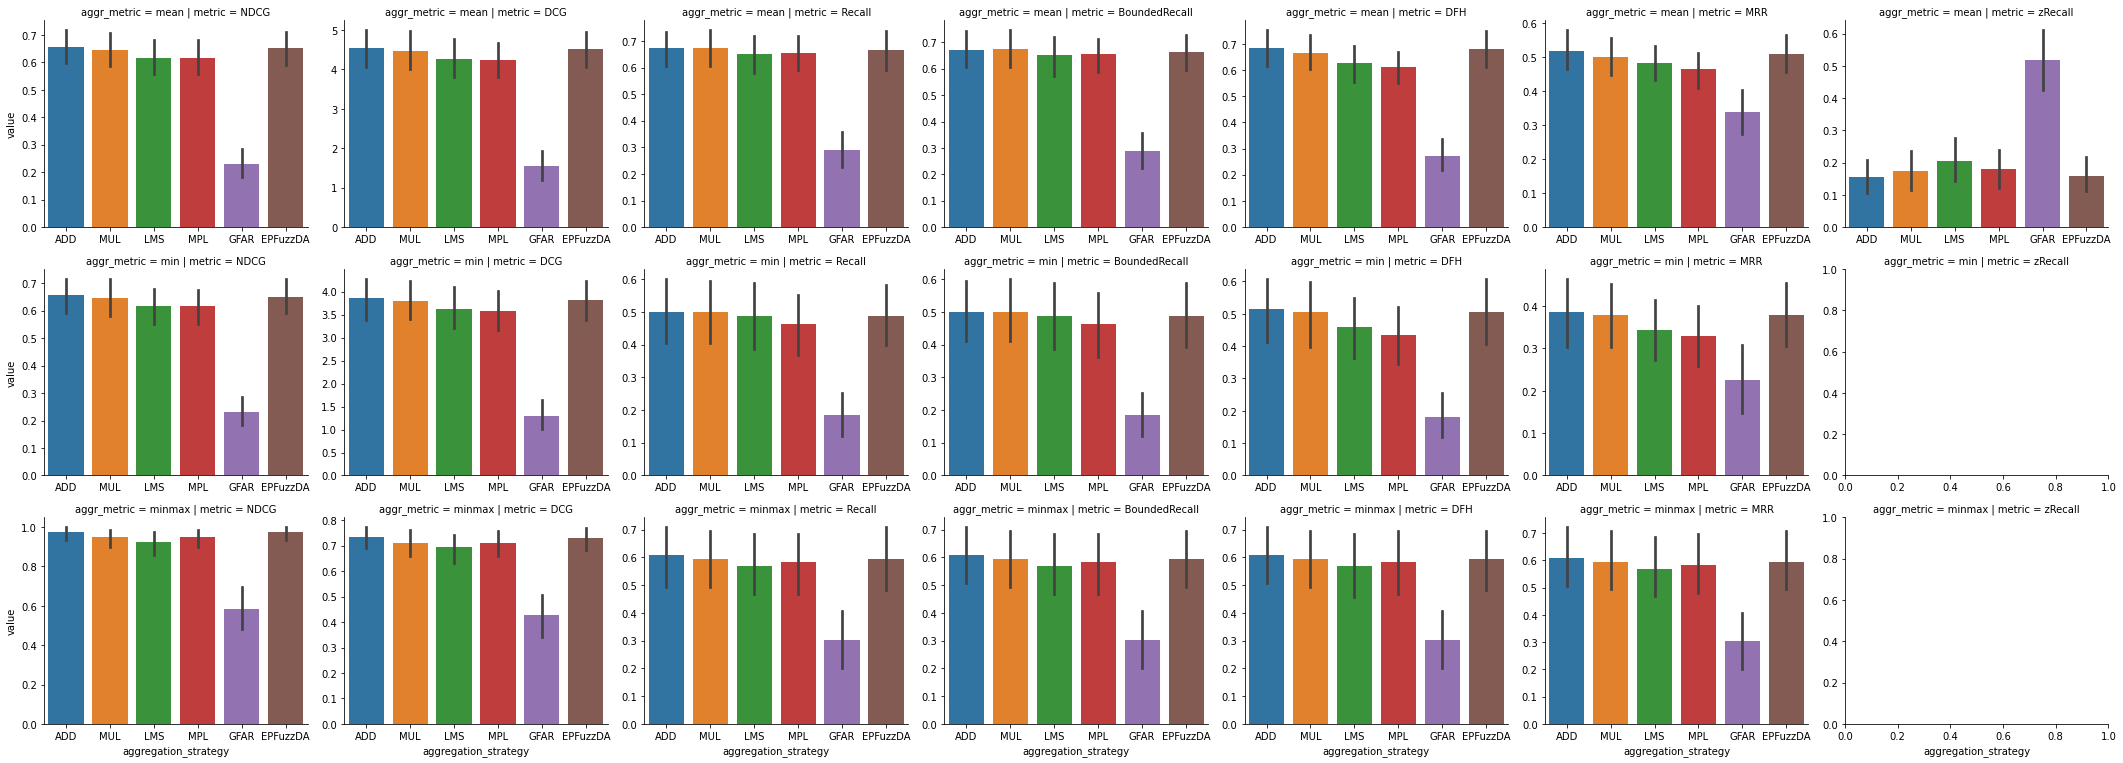

In [34]:
all_group_res = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().reset_index()

g = sns.catplot(data=eval_df, col="metric", row="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)


In [13]:
group_composition_DF = pd.DataFrame(group_composition).T
eval_df_with_group_info = group_composition_DF.join(eval_df.set_index("group_id"))
eval_df_with_group_info.head()

,group_size,group_members,group_similarity,metric,aggr_metric,value,aggregation_strategy,current_fold
1,4,"[26323, 42775, 41651, 32327]",divergent,NDCG,mean,0.613147,ADD,0
1,4,"[26323, 42775, 41651, 32327]",divergent,NDCG,min,0.613147,ADD,0
1,4,"[26323, 42775, 41651, 32327]",divergent,NDCG,minmax,1.000000,ADD,0
1,4,"[26323, 42775, 41651, 32327]",divergent,DCG,mean,6.250000,ADD,0
1,4,"[26323, 42775, 41651, 32327]",divergent,DCG,min,5.000000,ADD,0


### Metric variance per group size; keeping the aggregation strategies visible

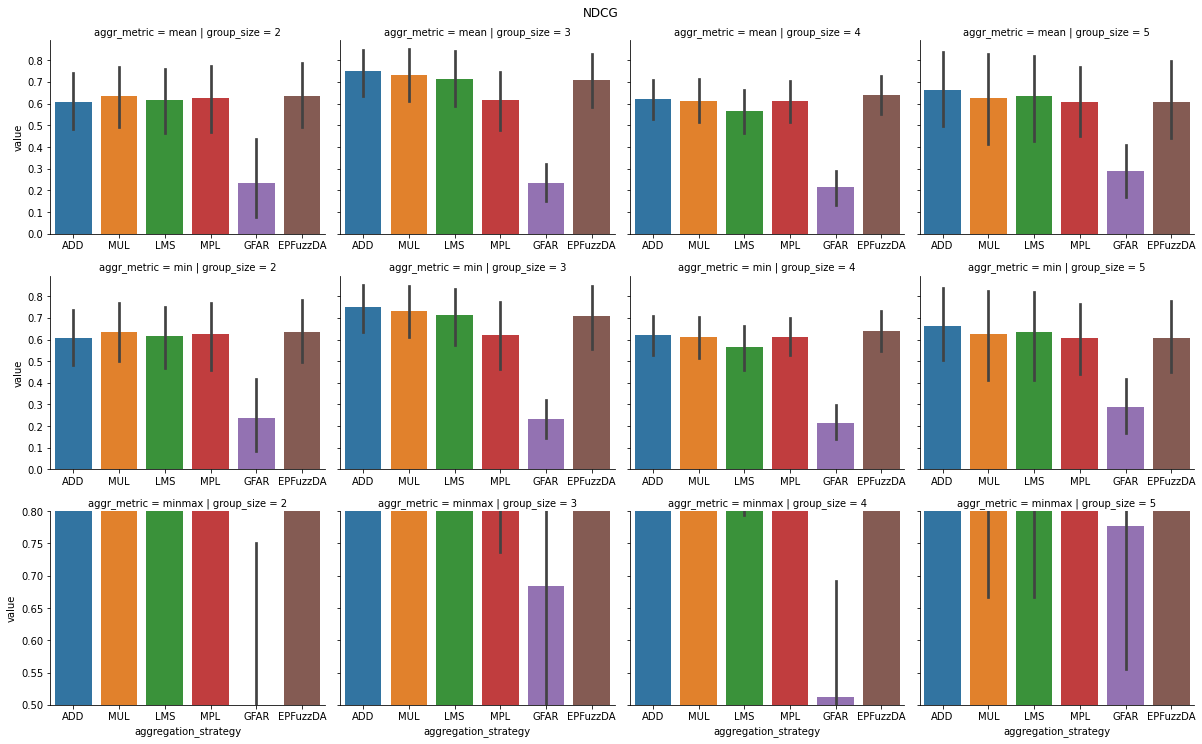

In [14]:
metric = "NDCG"
g = sns.catplot(data=eval_df_with_group_info.loc[eval_df_with_group_info.metric==metric], col="group_size", row="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey="row",
                   kind="bar",  height=3.5, aspect=1.2)
plt.suptitle(metric)
plt.ylim([0.5,0.8])
plt.tight_layout()


### Metric variance per group size; merging all aggregation strategies

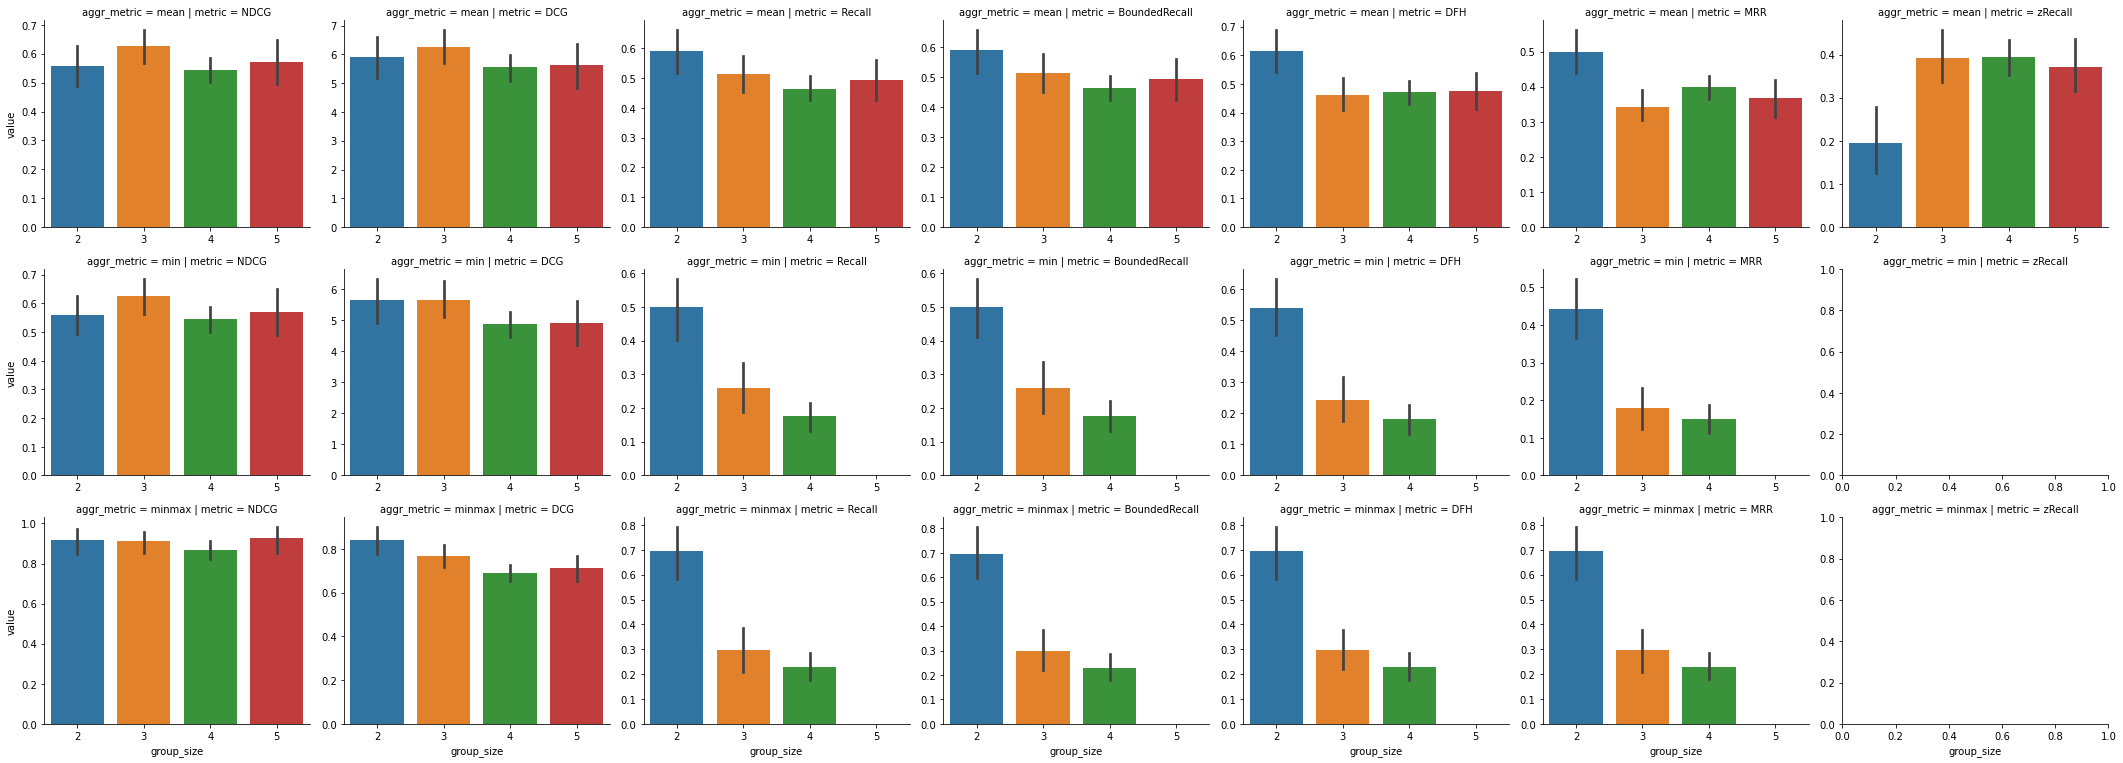

In [15]:
g = sns.catplot(data=eval_df_with_group_info, col="metric", row="aggr_metric", 
                   x="group_size", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)


### Metric variance per group size and group type; merging all aggregation strategies

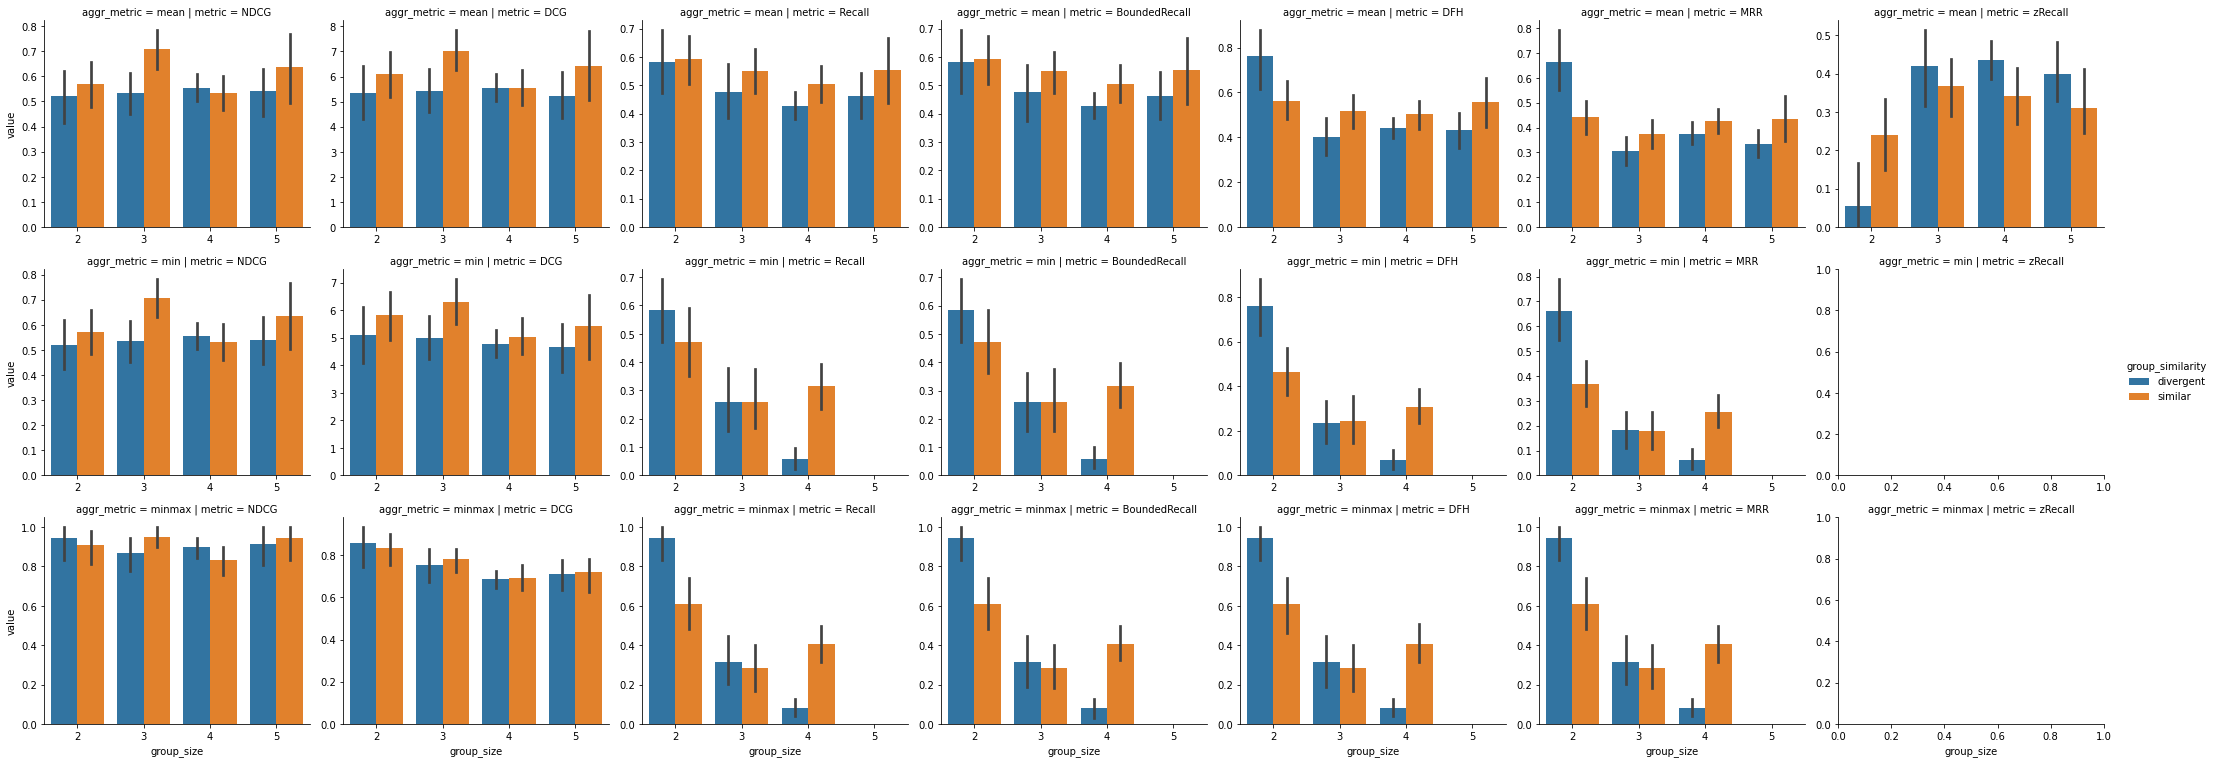

In [16]:
g = sns.catplot(data=eval_df_with_group_info, hue="group_similarity", col="metric", row="aggr_metric", 
                   x="group_size", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)

### Depict distribution of per-group values for all metrics

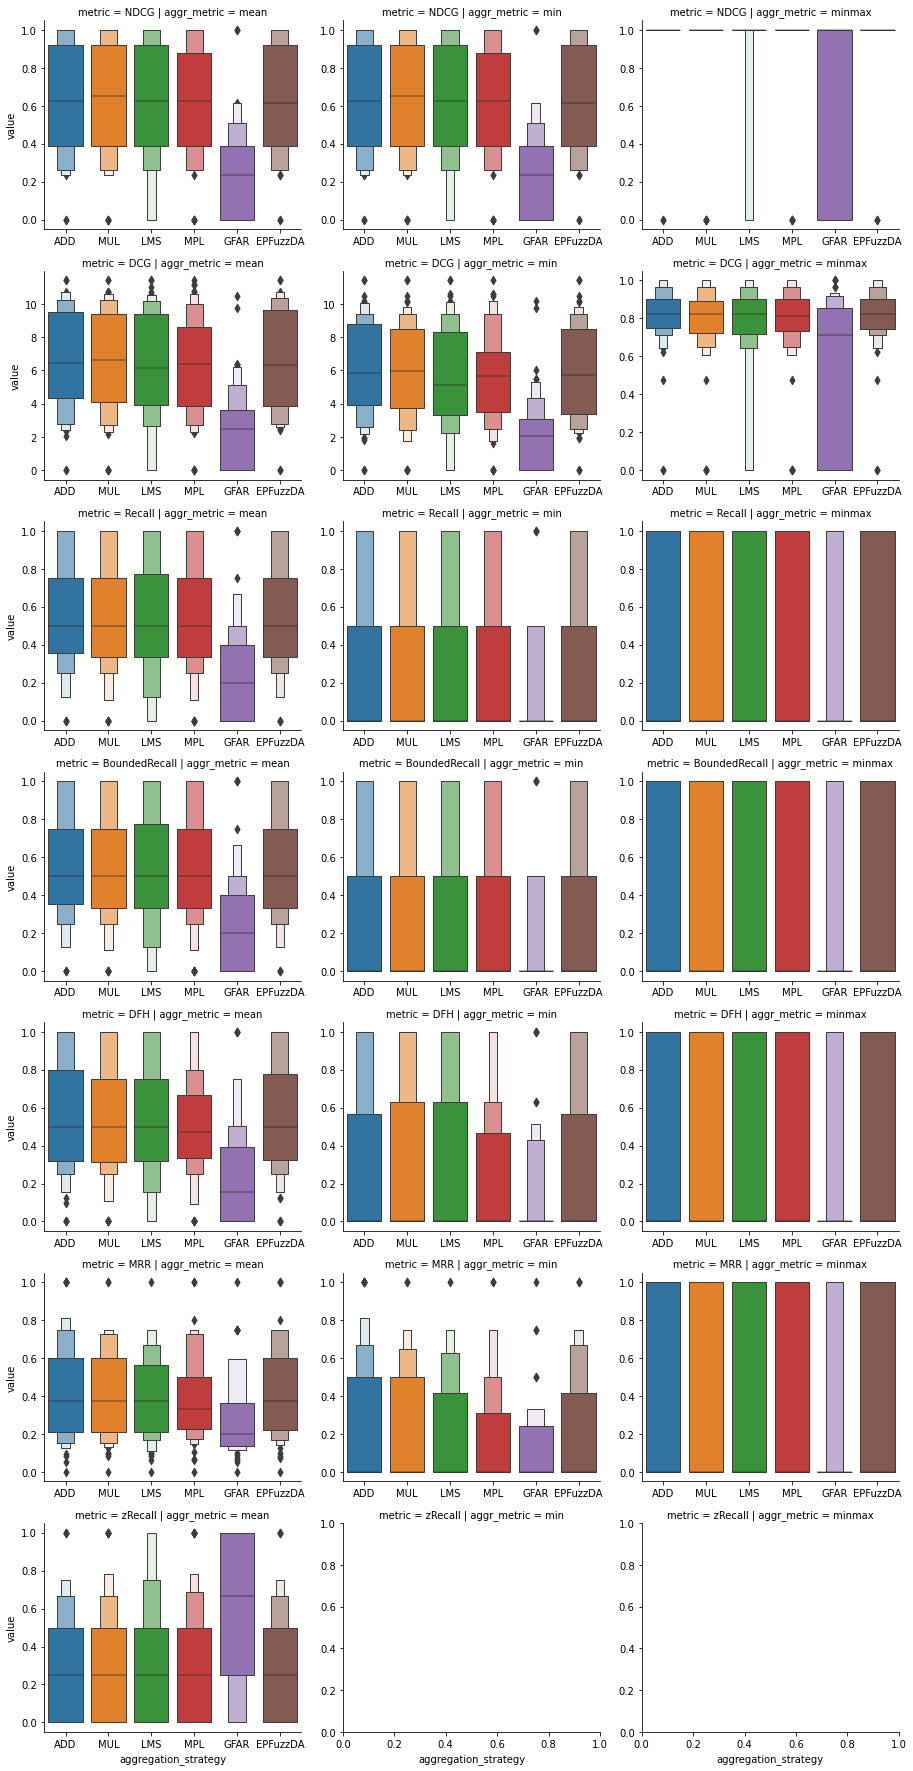

In [17]:
g = sns.catplot(data=eval_df, row="metric", col="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="boxen",  height=3.5, aspect=1.2)

In [18]:
#group_folds = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy', 'group_id']).mean()
#display(group_folds['value'].reset_index().sort_values(by='group_id'))

In [19]:
#eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().head(50)

# Compare results of multiple evaluation runs
### Collect all results and extend eval_df with relevant evaluation parameters

In [35]:
#get all evaluation runs specified in valid_rows
def get_valid_evaluation_data(valid_rows):
    eval_df_list = []
    for res in valid_rows:
        path_to_eval_folder = preprocessed_dataset_folder + "/" + res
        eval_df = pickle.load(open(path_to_eval_folder+"/eval_df.pkl", "rb"))    
        for c in parameters_df_relevant.columns:
            eval_df[c]=parameters_df_relevant.loc[res,c]
        eval_df_list.append(eval_df)

    eval_df_concat = pd.concat(eval_df_list)
    return eval_df_concat

In [36]:
#select only those evaluation runs we consider interesting
valid_rows = parameters_df_relevant.index[:]
parameters_df_relevant.loc[valid_rows]

,evaluation_ground_truth,binarize_feedback_positive_threshold
eval_1663520269.0354974,GROUP_CHOICES,4.0
eval_1663520278.0285046,USER_RATINGS,6.0
eval_1663520287.251507,USER_SATISFACTION,3.5


In [37]:
eval_df_concat = get_valid_evaluation_data(valid_rows)
eval_df_concat = eval_df_concat.loc[eval_df_concat.aggr_metric=="mean"] #GROUP CHOICES only support this one

group_composition_DF = pd.DataFrame(group_composition).T
eval_df_concat_with_group_info = group_composition_DF.join(eval_df_concat.set_index("group_id"))
eval_df_concat_with_group_info.head(3)

,group_size,group_members,group_similarity,metric,aggr_metric,value,aggregation_strategy,current_fold,evaluation_ground_truth,binarize_feedback_positive_threshold
1,4,"[26323, 42775, 41651, 32327]",divergent,NDCG,mean,0.613147,ADD,0,GROUP_CHOICES,4.0
1,4,"[26323, 42775, 41651, 32327]",divergent,DCG,mean,1.000000,ADD,0,GROUP_CHOICES,4.0
1,4,"[26323, 42775, 41651, 32327]",divergent,Recall,mean,0.500000,ADD,0,GROUP_CHOICES,4.0


### Comparing different ground truth definitions: individual rating / group choice / choice satisfaction

In [38]:
eval_df_concat_with_group_info.loc[((eval_df_concat_with_group_info.evaluation_ground_truth=="GROUP_CHOICES")&(eval_df_concat_with_group_info.metric=="Recall"))]

,group_size,group_members,group_similarity,metric,aggr_metric,value,aggregation_strategy,current_fold,evaluation_ground_truth,binarize_feedback_positive_threshold
1,4,"[26323, 42775, 41651, 32327]",divergent,Recall,mean,0.5,ADD,0,GROUP_CHOICES,4.0
1,4,"[26323, 42775, 41651, 32327]",divergent,Recall,mean,0.5,MUL,0,GROUP_CHOICES,4.0
1,4,"[26323, 42775, 41651, 32327]",divergent,Recall,mean,0.5,LMS,0,GROUP_CHOICES,4.0
1,4,"[26323, 42775, 41651, 32327]",divergent,Recall,mean,0.5,MPL,0,GROUP_CHOICES,4.0
1,4,"[26323, 42775, 41651, 32327]",divergent,Recall,mean,0.5,GFAR,0,GROUP_CHOICES,4.0
...,...,...,...,...,...,...,...,...,...,...
87,2,"[92076, 71467]",similar,Recall,mean,1.0,MUL,0,GROUP_CHOICES,4.0
87,2,"[92076, 71467]",similar,Recall,mean,1.0,LMS,0,GROUP_CHOICES,4.0
87,2,"[92076, 71467]",similar,Recall,mean,1.0,MPL,0,GROUP_CHOICES,4.0
87,2,"[92076, 71467]",similar,Recall,mean,0.0,GFAR,0,GROUP_CHOICES,4.0


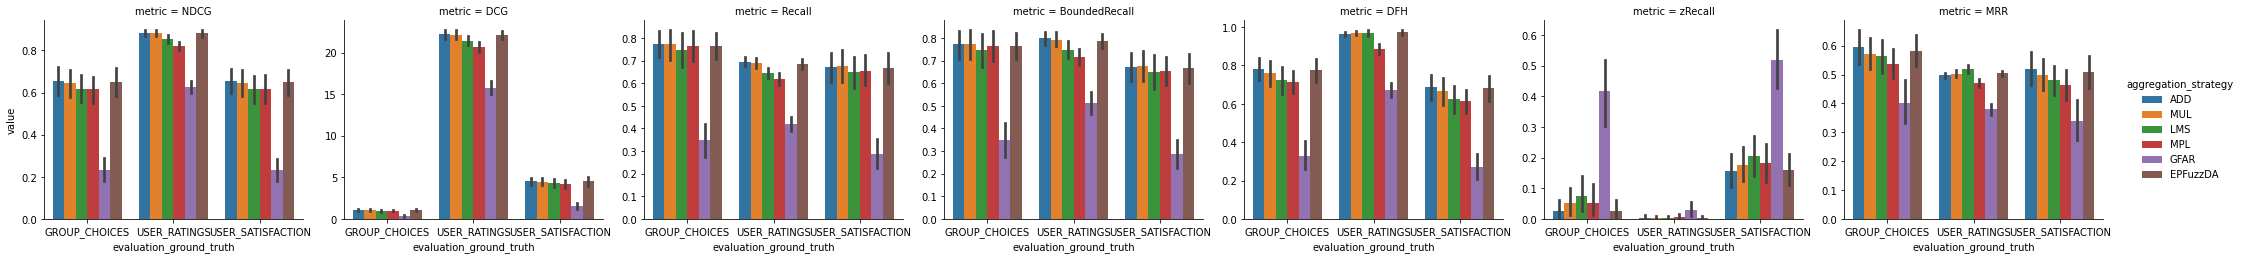

In [39]:
g = sns.catplot(data=eval_df_concat, x="evaluation_ground_truth", 
                col="metric", 
                hue="aggregation_strategy", y="value", sharex="col", sharey=False,
                kind="bar",  height=3.5, aspect=1.2)

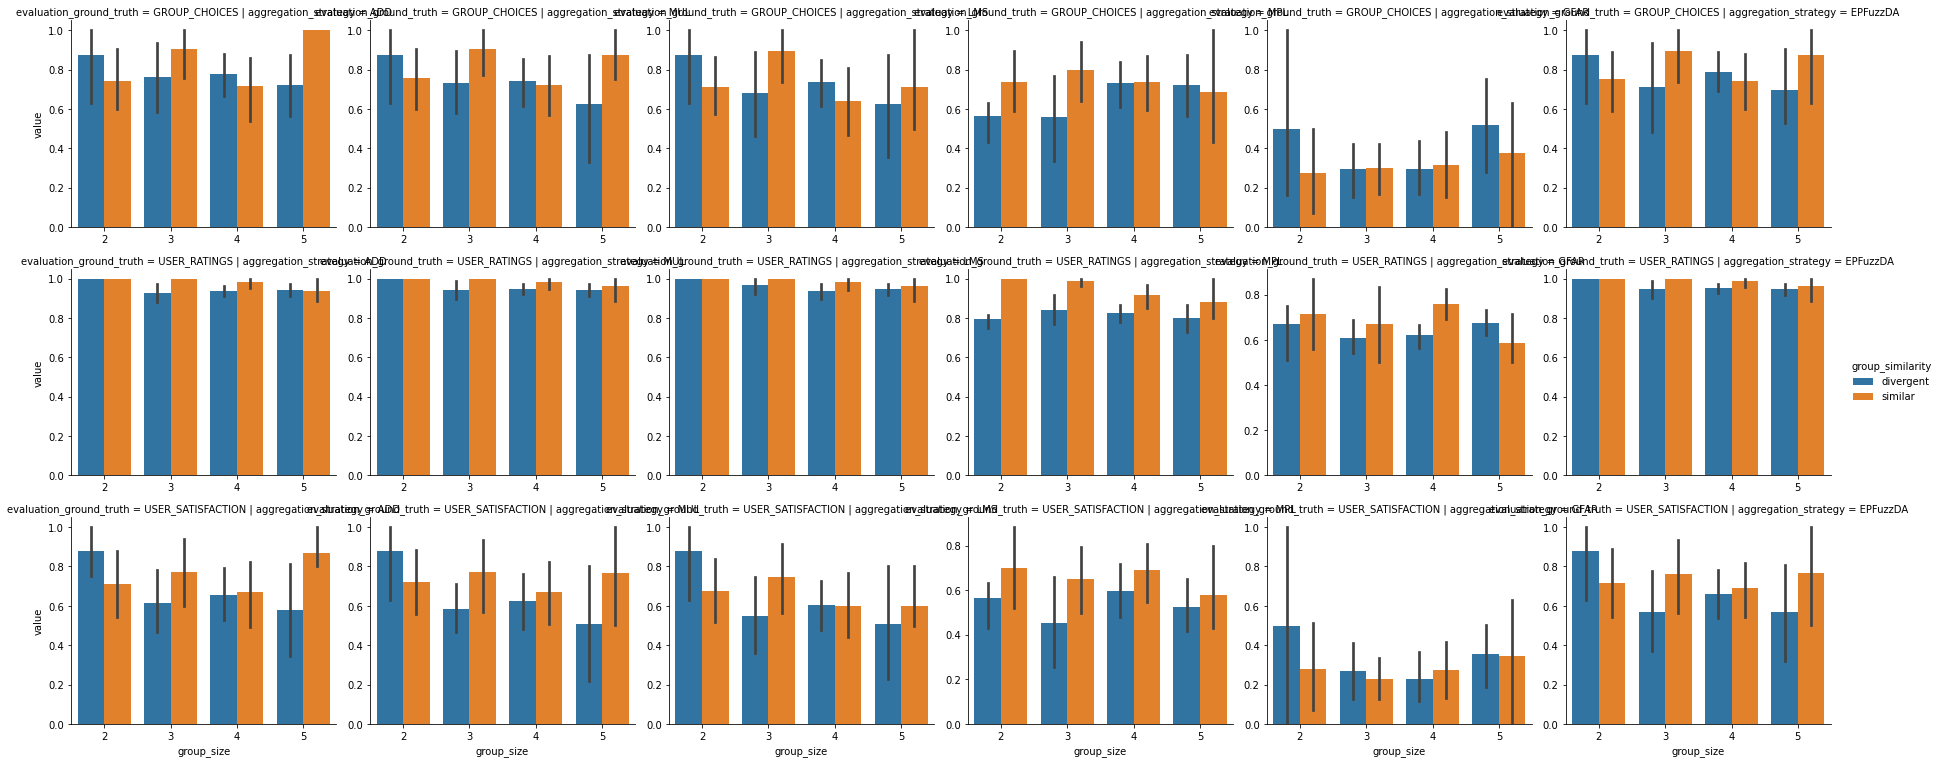

In [40]:
metric = "DFH"
g = sns.catplot(data=eval_df_concat_with_group_info.loc[eval_df_concat_with_group_info.metric==metric],  
                hue="group_similarity", x="group_size", 
                col="aggregation_strategy", row="evaluation_ground_truth", y="value", sharex=False, sharey=False,
                kind="bar",  height=3.5, aspect=1.2)